# Fine-tuning PhoRanker for RAG Chatbot

This notebook fine-tunes the `itdainb/PhoRanker` CrossEncoder model using training data from MongoDB.

**Configuration:**
- Loss: BCEWithLogitsLoss (Binary Cross Entropy)
- Batch Size: 4 per device, gradient accumulation steps: 4 (effective batch size: 16)
- Early Stopping: patience=3 evaluations
- Data: ALL available generated queries + BM25 hard negatives
- No data augmentation

**Output:** Trained model saved to `../reranker_finetune/`

## 1. Setup and Imports

In [2]:
import os
import sys
import json
import logging
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch

# Sentence Transformers
from sentence_transformers import CrossEncoder, InputExample
from sentence_transformers.cross_encoder.evaluation import CrossEncoderClassificationEvaluator

# MongoDB
from pymongo import MongoClient
from dotenv import load_dotenv

# Load environment variables first
load_dotenv()

# Device detection function (no Django needed)
def get_device():
    """Get the best available device for PyTorch."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✓ Imports complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ Imports complete
PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 2. Configuration

In [3]:
# Model Configuration
BASE_MODEL = "itdainb/PhoRanker"
OUTPUT_DIR = Path("../reranker_finetune")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Training Configuration
TRAINING_CONFIG = {
    "per_device_train_batch_size": 4,
    "gradient_accumulation_steps": 4,  # Effective batch size = 16
    "num_epochs": 10,
    "learning_rate": 2e-5,
    "warmup_ratio": 0.1,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "logging_steps": 50,
    "early_stopping_patience": 3,  # Stop if validation loss doesn't improve for 3 epochs
    "val_split": 0.2,  # 80/20 train/validation split
    "random_seed": 42
}

# LoRA Configuration
LORA_CONFIG = {
    "r": 8,
    "lora_alpha": 16,
    "lora_dropout": 0.05,
    "target_modules": ["query", "value"],
    "bias": "none"
}

# Device
device = get_device()
logger.info(f"Using device: {device}")

print("Configuration:")
print(f"  Base Model: {BASE_MODEL}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  Effective Batch Size: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"  Num Epochs: {TRAINING_CONFIG['num_epochs']}")
print(f"  Early Stopping Patience: {TRAINING_CONFIG['early_stopping_patience']}")
print(f"  Device: {device}")
print(f"  LoRA target_modules: {LORA_CONFIG['target_modules']}")

2025-12-14 14:30:30,164 - INFO - Using device: cuda


Configuration:
  Base Model: itdainb/PhoRanker
  Output Directory: ..\reranker_finetune
  Effective Batch Size: 16
  Num Epochs: 10
  Early Stopping Patience: 3
  Device: cuda
  LoRA target_modules: ['query', 'value']


In [4]:
# --- OPTIMIZED CONFIGURATION ---

# 1. Disable LoRA (Set to None)
LORA_CONFIG = None 

TRAINING_CONFIG = {
    # Hardware Optimization for RTX 3050
    "per_device_train_batch_size": 4,   # Keeps VRAM usage low (~2.8GB)
    "gradient_accumulation_steps": 4,   # Effective Batch Size = 16 (Stable)
    "fp16": True,                       # Enable Mixed Precision (Crucial for VRAM savings)
    
    # Training Strategy
    "num_epochs": 4,                    # Cap at 4 to prevent overfitting
    "learning_rate": 2e-5,              # Standard for Full Fine-Tuning
    "warmup_ratio": 0.1,
    
    # Evaluation & Saving
    "evaluation_strategy": "steps",     # Evaluate more often than just "epoch"
    "eval_steps": 100,                  # Check val_loss every 100 steps
    "save_strategy": "steps",
    "save_steps": 100,
    "save_total_limit": 2,              # Only keep the top 2 best checkpoints (Saves Disk)
    "load_best_model_at_end": True,     # Auto-load the best checkpoint
    
    # Logging
    "logging_steps": 10,                # Frequent logs for granular graphs
    "report_to": "none",                # Disable WandB/Tensorboard if not installed
    
    # Early Stopping
    "early_stopping_patience": 2,       # Stop fast if no improvement
    "val_split": 0.1,                   # 10% is enough for 1.2k samples
    "random_seed": 42
}

## 3. Load Training Data from MongoDB

In [5]:
# Connect to MongoDB with proper error handling
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017")
MONGO_DB_NAME = os.getenv("MONGO_DB_NAME", "rag_chatbot")

# Validate and fix MongoDB URI
if "mongo:" in MONGO_URI:
    logger.warning(f"Docker URI detected: {MONGO_URI}")
    MONGO_URI = "mongodb://localhost:27017"
    logger.info(f"Overriding to local URI: {MONGO_URI}")

print(f"Connecting to MongoDB: {MONGO_URI}")
print(f"Using database: {MONGO_DB_NAME}")

try:
    # Connect with explicit timeout settings
    client = MongoClient(
        MONGO_URI,
        serverSelectionTimeoutMS=5000,
        socketTimeoutMS=5000,
        connectTimeoutMS=5000,
        retryWrites=False
    )
    
    # Test connection
    client.admin.command('ping')
    logger.info("✓ MongoDB connection successful")
    
except Exception as e:
    raise ConnectionError(
        f"Failed to connect to MongoDB at {MONGO_URI}.\n"
        f"Error: {str(e)}\n"
        f"Ensure MongoDB is running: mongosh --eval \"db.adminCommand('ping')\""
    )

# Explicitly use rag_chatbot database
db = client["rag_chatbot"]

# Collections
training_set_col = db["training_set"]
trainset_neg_col = db["trainset_neg"]
chunks_col = db["chunks"]

# Check data availability
training_count = training_set_col.count_documents({})
negatives_count = trainset_neg_col.count_documents({})
chunks_count = chunks_col.count_documents({})

print(f"MongoDB Collections in 'rag_chatbot':")
print(f"  training_set: {training_count:,} documents")
print(f"  trainset_neg: {negatives_count:,} documents")
print(f"  chunks: {chunks_count:,} documents")

if training_count == 0:
    raise ValueError("No training data found in MongoDB! Run generate_training_queries.py first.")
if negatives_count == 0:
    raise ValueError("No hard negatives found in MongoDB! Run mine_hard_negatives.py first.")

2025-12-14 14:30:34,975 - WARNING - Docker URI detected: mongodb://mongo:27017
2025-12-14 14:30:34,975 - INFO - Overriding to local URI: mongodb://localhost:27017
2025-12-14 14:30:35,006 - INFO - ✓ MongoDB connection successful


Connecting to MongoDB: mongodb://localhost:27017
Using database: rag_db
MongoDB Collections in 'rag_chatbot':
  training_set: 1,103 documents
  trainset_neg: 3,309 documents
  chunks: 2,003 documents


## 4. Build Training Examples (Query-Chunk Pairs)

In [6]:
def build_training_examples() -> List[InputExample]:
    """
    Build training examples from MongoDB:
    - Positive examples: (query, chunk_text, label=1)
    - Negative examples: (query, negative_chunk_text, label=0)
    """
    examples = []
    
    # Load all chunks into memory for fast lookup
    logger.info("Loading chunks...")
    chunks_dict = {}
    for chunk in chunks_col.find():
        chunks_dict[chunk["_id"]] = chunk["text"]
    
    logger.info(f"Loaded {len(chunks_dict):,} chunks")
    
    # Build positive examples from training_set
    logger.info("Building positive examples...")
    positive_count = 0
    for doc in training_set_col.find():
        chunk_id = doc["chunk_id"]
        chunk_text = doc.get("chunk_text") or chunks_dict.get(chunk_id)
        
        if not chunk_text:
            continue
            
        # Each document has 3 generated queries
        for query in doc.get("queries", []):
            examples.append(InputExample(texts=[query, chunk_text], label=1.0))
            positive_count += 1
    
    logger.info(f"Built {positive_count:,} positive examples")
    
    # Build negative examples from trainset_neg (BM25 hard negatives)
    logger.info("Building negative examples...")
    negative_count = 0
    for doc in trainset_neg_col.find():
        query = doc["query"]
        negative_chunk_id = doc["negative_chunk_id"]
        negative_chunk_text = chunks_dict.get(negative_chunk_id)
        
        if not negative_chunk_text:
            continue
            
        examples.append(InputExample(texts=[query, negative_chunk_text], label=0.0))
        negative_count += 1
    
    logger.info(f"Built {negative_count:,} negative examples")
    logger.info(f"Total examples: {len(examples):,}")
    logger.info(f"Positive/Negative ratio: {positive_count}/{negative_count} = {positive_count/negative_count:.2f}")
    
    return examples

# Build all training examples
all_examples = build_training_examples()

print(f"\n✓ Training data prepared:")
print(f"  Total examples: {len(all_examples):,}")
print(f"  Sample positive example: {all_examples[0].texts[0][:80]}... -> {all_examples[0].texts[1][:80]}... (label={all_examples[0].label})")
print(f"  Sample negative example: {all_examples[-1].texts[0][:80]}... -> {all_examples[-1].texts[1][:80]}... (label={all_examples[-1].label})")

2025-12-14 14:30:37,794 - INFO - Loading chunks...
2025-12-14 14:30:37,919 - INFO - Loaded 2,003 chunks
2025-12-14 14:30:37,920 - INFO - Building positive examples...
2025-12-14 14:30:37,932 - INFO - Built 3,309 positive examples
2025-12-14 14:30:37,933 - INFO - Building negative examples...
2025-12-14 14:30:37,993 - INFO - Built 3,309 negative examples
2025-12-14 14:30:37,994 - INFO - Total examples: 6,618
2025-12-14 14:30:37,995 - INFO - Positive/Negative ratio: 3309/3309 = 1.00



✓ Training data prepared:
  Total examples: 6,618
  Sample positive example: Lê Thị Hoàng Anh Công nghệ phần mềm... -> Giảng viên: Lê Thị Hoàng Anh Email: anhlth@huce.edu.vn Công nghệ phần mềm Chương... (label=1.0)
  Sample negative example: TRIGGER quản lý kho hàng, giảm số lượng sách khi bán và hủy giao dịch nếu không ... ->  Ví dụ ◦ Kiểm tra trước khi Commit giao dịch 2.4 Các câu lệnh xử lý giao dịch B... (label=0.0)


## 5. Train/Validation Split

In [7]:
# Split into train and validation sets
np.random.seed(TRAINING_CONFIG["random_seed"])
indices = np.random.permutation(len(all_examples))

val_size = int(len(all_examples) * TRAINING_CONFIG["val_split"])
train_size = len(all_examples) - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_examples = [all_examples[i] for i in train_indices]
val_examples = [all_examples[i] for i in val_indices]

# Separate validation into positive and negative for evaluator
val_positive = [ex for ex in val_examples if ex.label == 1.0]
val_negative = [ex for ex in val_examples if ex.label == 0.0]

print(f"Dataset Split:")
print(f"  Training examples: {len(train_examples):,}")
print(f"  Validation examples: {len(val_examples):,}")
print(f"    - Positive: {len(val_positive):,}")
print(f"    - Negative: {len(val_negative):,}")
print(f"  Split ratio: {100*(1-TRAINING_CONFIG['val_split']):.0f}/{100*TRAINING_CONFIG['val_split']:.0f}")

Dataset Split:
  Training examples: 5,957
  Validation examples: 661
    - Positive: 320
    - Negative: 341
  Split ratio: 90/10


## 6. Initialize Model and Evaluator

In [ ]:
import math
from peft import LoraConfig, TaskType, get_peft_model

# Load base model
logger.info(f"Loading base model: {BASE_MODEL}")
model = CrossEncoder(BASE_MODEL, num_labels=1, device=device)

print(f"✓ Model loaded: {BASE_MODEL}")
print(f"  Device: {model.device}")
print(f"  Max sequence length: {model.max_length}")

def _print_trainable_parameters(torch_model: torch.nn.Module) -> None:
    trainable = 0
    total = 0
    for p in torch_model.parameters():
        total += p.numel()
        if p.requires_grad:
            trainable += p.numel()
    pct = 100 * trainable / max(total, 1)
    print(f"Trainable params: {trainable:,} / {total:,} ({pct:.2f}%)")

# Apply LoRA to the underlying Transformers model
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=LORA_CONFIG["r"],
    lora_alpha=LORA_CONFIG["lora_alpha"],
    lora_dropout=LORA_CONFIG["lora_dropout"],
    target_modules=LORA_CONFIG["target_modules"],
    bias=LORA_CONFIG["bias"],
    inference_mode=False,
)

model.model = get_peft_model(model.model, lora_cfg)

print("✓ LoRA applied")
_print_trainable_parameters(model.model)

# Evaluator: returns loss + classification metrics
def evaluate_binary_classification(model, val_examples, threshold=0.5, batch_size=32):
    """
    Evaluator for binary classification with BCEWithLogitsLoss.
    Returns validation loss + metrics based on sigmoid threshold.
    """
    model.model.eval()

    loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")

    all_probs = []
    all_labels = []
    total_loss = 0.0
    total_count = 0

    for i in range(0, len(val_examples), batch_size):
        batch = val_examples[i : i + batch_size]
        texts = [ex.texts for ex in batch]
        labels = torch.tensor([ex.label for ex in batch], dtype=torch.float, device=device)

        features = model.tokenizer(
            [t[0] for t in texts],
            [t[1] for t in texts],
            padding=True,
            truncation=True,
            max_length=model.max_length,
            return_tensors="pt",
        ).to(device)

        with torch.no_grad():
            outputs = model.model(**features)
            logits = outputs.logits.squeeze(-1)

            loss = loss_fn(logits, labels)
            probs = torch.sigmoid(logits)

        bs = labels.shape[0]
        total_loss += loss.item() * bs
        total_count += bs

        all_probs.append(probs.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    probs = np.concatenate(all_probs, axis=0) if all_probs else np.array([])
    labels = np.concatenate(all_labels, axis=0) if all_labels else np.array([])
    val_loss = total_loss / max(total_count, 1)

    preds = (probs >= threshold).astype(float)

    accuracy = float(np.mean(preds == labels)) if labels.size else 0.0
    true_positives = float(np.sum((preds == 1) & (labels == 1)))
    false_positives = float(np.sum((preds == 1) & (labels == 0)))
    false_negatives = float(np.sum((preds == 0) & (labels == 1)))

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    return {
        "loss": float(val_loss),
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "threshold": threshold,
    }

print(f"✓ Evaluator ready for {len(val_examples):,} validation examples")

In [8]:
# ...existing code...
import math

# Load base model
logger.info(f"Loading base model: {BASE_MODEL}")
model = CrossEncoder(BASE_MODEL, num_labels=1, device=device)

print(f"✓ Model loaded: {BASE_MODEL}")
print(f"  Device: {model.device}")
print(f"  Max sequence length: {model.max_length}")

def _print_trainable_parameters(torch_model: torch.nn.Module) -> None:
    trainable = 0
    total = 0
    for p in torch_model.parameters():
        total += p.numel()
        if p.requires_grad:
            trainable += p.numel()
    pct = 100 * trainable / max(total, 1)
    print(f"Trainable params: {trainable:,} / {total:,} ({pct:.2f}%)")

# Apply LoRA only if configured
if LORA_CONFIG is not None:
    from peft import LoraConfig, TaskType, get_peft_model

    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=LORA_CONFIG["r"],
        lora_alpha=LORA_CONFIG["lora_alpha"],
        lora_dropout=LORA_CONFIG["lora_dropout"],
        target_modules=LORA_CONFIG["target_modules"],
        bias=LORA_CONFIG["bias"],
        inference_mode=False,
    )
    model.model = get_peft_model(model.model, lora_cfg)
    print("✓ LoRA applied")
else:
    print("✓ LoRA disabled (full fine-tuning)")

_print_trainable_parameters(model.model)

# Evaluator: returns loss + classification metrics
def evaluate_binary_classification(model, val_examples, threshold=0.5, batch_size=32):
    """
    Evaluator for binary classification with BCEWithLogitsLoss.
    Returns validation loss + metrics based on sigmoid threshold.
    """
    model.model.eval()
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")

    all_probs = []
    all_labels = []
    total_loss = 0.0
    total_count = 0

    for i in range(0, len(val_examples), batch_size):
        batch = val_examples[i : i + batch_size]
        texts = [ex.texts for ex in batch]
        labels = torch.tensor([ex.label for ex in batch], dtype=torch.float, device=device)

        features = model.tokenizer(
            [t[0] for t in texts],
            [t[1] for t in texts],
            padding=True,
            truncation=True,
            max_length=model.max_length,
            return_tensors="pt",
        ).to(device)

        with torch.no_grad():
            outputs = model.model(**features)
            logits = outputs.logits.squeeze(-1)

            loss = loss_fn(logits, labels)
            probs = torch.sigmoid(logits)

        bs = labels.shape[0]
        total_loss += loss.item() * bs
        total_count += bs

        all_probs.append(probs.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    probs = np.concatenate(all_probs, axis=0) if all_probs else np.array([])
    labels = np.concatenate(all_labels, axis=0) if all_labels else np.array([])
    val_loss = total_loss / max(total_count, 1)

    preds = (probs >= threshold).astype(float)

    accuracy = float(np.mean(preds == labels)) if labels.size else 0.0
    true_positives = float(np.sum((preds == 1) & (labels == 1)))
    false_positives = float(np.sum((preds == 1) & (labels == 0)))
    false_negatives = float(np.sum((preds == 0) & (labels == 1)))

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    return {
        "loss": float(val_loss),
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "threshold": threshold,
    }

print(f"✓ Evaluator ready for {len(val_examples):,} validation examples")
# ...existing code...

2025-12-14 14:30:42,871 - INFO - Loading base model: itdainb/PhoRanker


✓ Model loaded: itdainb/PhoRanker
  Device: cuda:0
  Max sequence length: 256
✓ LoRA disabled (full fine-tuning)
Trainable params: 134,999,041 / 134,999,041 (100.00%)
✓ Evaluator ready for 661 validation examples


## 7. Training with Early Stopping

In [9]:
class EarlyStoppingCallback:
    """Early stopping callback (supports min/max)."""
    def __init__(self, patience=3, min_delta=0.001, mode="min"):
        if mode not in ("min", "max"):
            raise ValueError("mode must be 'min' or 'max'")
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.should_stop = False
        self.best_epoch = 0

    def __call__(self, score, epoch):
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            return False

        improved = False
        if self.mode == "min":
            improved = score < (self.best_score - self.min_delta)
        else:
            improved = score > (self.best_score + self.min_delta)

        if improved:
            self.best_score = score
            self.counter = 0
            self.best_epoch = epoch
            logger.info(f"  → Validation improved! New best: {score:.6f}")
        else:
            self.counter += 1
            logger.info(f"  → No improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.should_stop = True
                logger.info(f"  → Early stopping triggered at epoch {epoch}")

        return self.should_stop

# Minimize validation loss
early_stopping = EarlyStoppingCallback(
    patience=TRAINING_CONFIG["early_stopping_patience"],
    min_delta=0.0,
    mode="min",
)

training_history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "learning_rate": [],
}

print("Starting training...")
print(f"  Epochs: {TRAINING_CONFIG['num_epochs']}")
print(f"  Batch size (per device): {TRAINING_CONFIG['per_device_train_batch_size']}")
print(f"  Gradient accumulation steps: {TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"  Effective batch size: {TRAINING_CONFIG['per_device_train_batch_size'] * TRAINING_CONFIG['gradient_accumulation_steps']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")
print(f"  Warmup ratio: {TRAINING_CONFIG['warmup_ratio']}")
print("")

Starting training...
  Epochs: 4
  Batch size (per device): 4
  Gradient accumulation steps: 4
  Effective batch size: 16
  Learning rate: 2e-05
  Warmup ratio: 0.1



In [ ]:
import time
import math
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from tqdm.auto import tqdm

# Train only LoRA parameters
trainable_params = [p for p in model.model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=TRAINING_CONFIG["learning_rate"])

batch_size = TRAINING_CONFIG["per_device_train_batch_size"]
grad_accum = TRAINING_CONFIG["gradient_accumulation_steps"]

num_batches_total = math.ceil(len(train_examples) / batch_size)
steps_per_epoch = math.ceil(num_batches_total / grad_accum)
total_optimizer_steps = steps_per_epoch * TRAINING_CONFIG["num_epochs"]

scheduler = LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.0,
    total_iters=max(total_optimizer_steps, 1),
)

# Best model tracking (by validation loss)
best_model_path = OUTPUT_DIR / "best_model"          # merged full model output
best_adapter_path = OUTPUT_DIR / "best_adapter"      # adapter-only during training
best_val_loss = float("inf")
best_epoch = 0
# --- NEW: checkpoint folder + helper ---
checkpoints_dir = OUTPUT_DIR / "checkpoints"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

def save_epoch_checkpoint(epoch: int, val_results: dict, avg_train_loss: float) -> None:
    """Save adapter + optimizer/scheduler/training history for resuming/debugging."""
    epoch_dir = checkpoints_dir / f"epoch_{epoch:03d}"
    epoch_dir.mkdir(parents=True, exist_ok=True)

    # 1) Save adapter weights/config for this epoch
    adapter_dir = epoch_dir / "adapter"
    model.model.save_pretrained(str(adapter_dir))

    # 2) Save trainer state (for potential resume)
    trainer_state = {
        "epoch": int(epoch),
        "avg_train_loss": float(avg_train_loss),
        "val_results": {k: (float(v) if isinstance(v, (int, float)) else v) for k, v in val_results.items()},
        "best_val_loss": float(best_val_loss),
        "best_epoch": int(best_epoch),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "training_config": TRAINING_CONFIG,
        "lora_config": LORA_CONFIG,
        "training_history": training_history,
    }
    torch.save(trainer_state, str(epoch_dir / "trainer_state.pt"))

    # 3) Also write a small JSON summary (easy to inspect without torch.load)
    with open(epoch_dir / "summary.json", "w", encoding="utf-8") as f:
        json.dump(
            {
                "epoch": int(epoch),
                "avg_train_loss": float(avg_train_loss),
                "val_results": trainer_state["val_results"],
                "best_val_loss": float(best_val_loss),
                "best_epoch": int(best_epoch),
            },
            f,
            ensure_ascii=False,
            indent=2,
        )
epoch_pbar = tqdm(range(TRAINING_CONFIG["num_epochs"]), desc="Training", unit="epoch")

loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in epoch_pbar:
    epoch_start_time = time.time()
    model.model.train()
    optimizer.zero_grad()

    total_train_loss = 0.0
    num_batches = 0
    accum_steps = 0

    np.random.shuffle(train_examples)

    batch_pbar = tqdm(
        range(0, len(train_examples), batch_size),
        desc=f"Epoch {epoch}",
        leave=False,
        total=num_batches_total,
        unit="batch",
    )

    for step_idx, i in enumerate(batch_pbar, start=1):
        batch = train_examples[i : i + batch_size]
        texts = [ex.texts for ex in batch]
        labels = torch.tensor([ex.label for ex in batch], dtype=torch.float, device=device)

        features = model.tokenizer(
            [t[0] for t in texts],
            [t[1] for t in texts],
            padding=True,
            truncation=True,
            max_length=model.max_length,
            return_tensors="pt",
        ).to(device)

        outputs = model.model(**features)
        logits = outputs.logits.squeeze(-1)

        loss = loss_fn(logits, labels)
        (loss / grad_accum).backward()

        total_train_loss += loss.item()
        num_batches += 1
        accum_steps += 1

        batch_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        if accum_steps >= grad_accum:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            accum_steps = 0

    # Flush leftover grads
    if accum_steps > 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    batch_pbar.close()

    avg_train_loss = total_train_loss / max(num_batches, 1)
    epoch_time = time.time() - epoch_start_time

    epoch_pbar.write("\n  Running validation...")
    val_results = evaluate_binary_classification(model, val_examples)

    val_loss = val_results["loss"]
    val_acc = val_results["accuracy"]

    training_history["epoch"].append(epoch)
    training_history["train_loss"].append(avg_train_loss)
    training_history["val_loss"].append(val_loss)
    training_history["val_accuracy"].append(val_acc)
    training_history["learning_rate"].append(scheduler.get_last_lr()[0])

    epoch_pbar.set_postfix({
        "train_loss": f"{avg_train_loss:.4f}",
        "val_loss": f"{val_loss:.4f}",
        "val_acc": f"{val_acc:.4f}",
    })

    epoch_pbar.write(f"\nEpoch {epoch} Summary:")
    epoch_pbar.write(f"  Train Loss: {avg_train_loss:.6f}")
    epoch_pbar.write(f"  Val Loss:   {val_loss:.6f}")
    epoch_pbar.write(f"  Val Acc:    {val_acc:.6f}")
    epoch_pbar.write(f"  Val F1:     {val_results['f1']:.6f}")
    epoch_pbar.write(f"  Time:       {epoch_time:.1f}s")

    # Save best adapter (by val loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        model.model.save_pretrained(str(best_adapter_path))
        epoch_pbar.write(f"  Saved best LoRA adapter: {best_adapter_path} (val_loss: {best_val_loss:.6f})")
    save_epoch_checkpoint(epoch=epoch, val_results=val_results, avg_train_loss=avg_train_loss)
    epoch_pbar.write(f"  Saved epoch checkpoint: {checkpoints_dir / f'epoch_{epoch:03d}'}")
    # Early stopping (by val loss)
    if early_stopping(val_loss, epoch):
        epoch_pbar.write(f"\nEarly stopping at epoch {epoch}")
        break

epoch_pbar.close()

# Merge best adapter into base model and save a full CrossEncoder directory (deployment strategy)
from peft import PeftModel

merged_ce = CrossEncoder(BASE_MODEL, num_labels=1, device=device)
merged_ce.model = PeftModel.from_pretrained(merged_ce.model, str(best_adapter_path))
merged_ce.model = merged_ce.model.merge_and_unload()
merged_ce.save(str(best_model_path))

final_model_path = best_model_path

tqdm.write("\n✓ Training completed.")
tqdm.write(f"  Best epoch: {best_epoch} | best val_loss: {best_val_loss:.6f}")
tqdm.write(f"  Merged model saved to: {best_model_path}")

In [12]:
# ...existing code...
import time
import math
import shutil
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from tqdm.auto import tqdm

# Trainable params:
# - Full fine-tuning when LoRA_CONFIG is None
# - LoRA-only when enabled (requires_grad=True)
trainable_params = [p for p in model.model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=TRAINING_CONFIG["learning_rate"])

batch_size = TRAINING_CONFIG["per_device_train_batch_size"]
grad_accum = TRAINING_CONFIG["gradient_accumulation_steps"]

num_batches_total = math.ceil(len(train_examples) / batch_size)
steps_per_epoch = math.ceil(num_batches_total / grad_accum)
total_optimizer_steps = max(steps_per_epoch * TRAINING_CONFIG["num_epochs"], 1)

warmup_steps = int(total_optimizer_steps * TRAINING_CONFIG.get("warmup_ratio", 0.0))

def lr_lambda(step: int) -> float:
    # Warmup then linear decay to 0
    if warmup_steps > 0 and step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    remaining = total_optimizer_steps - step
    denom = max(1, total_optimizer_steps - warmup_steps)
    return max(0.0, float(remaining) / float(denom))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Mixed precision (CUDA only)
use_fp16 = bool(TRAINING_CONFIG.get("fp16", False)) and (device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)

# Best model tracking (by validation loss)
best_model_path = OUTPUT_DIR / "best_model"      # full model output
best_adapter_path = OUTPUT_DIR / "best_adapter"  # adapter-only if LoRA
best_val_loss = float("inf")
best_step = -1

# Checkpoints folder
checkpoints_dir = OUTPUT_DIR / "checkpoints"
checkpoints_dir.mkdir(parents=True, exist_ok=True)

saved_checkpoints = []  # list[(val_loss, path_str)]

def _rotate_checkpoints(save_total_limit: int) -> None:
    """Keep only the best-K checkpoints by val_loss."""
    if not save_total_limit or save_total_limit <= 0:
        return
    if len(saved_checkpoints) <= save_total_limit:
        return

    # Sort worst-first by val_loss, delete extras, then truncate list in-place
    saved_checkpoints.sort(key=lambda x: x[0], reverse=True)
    to_delete = saved_checkpoints[save_total_limit:]

    for _, ckpt_path in to_delete:
        try:
            shutil.rmtree(ckpt_path, ignore_errors=True)
        except Exception as e:
            logger.warning(f"Failed to delete checkpoint {ckpt_path}: {e}")

    del saved_checkpoints[save_total_limit:]

def save_step_checkpoint(step: int, val_results: dict | None, avg_train_loss: float, epoch: int) -> None:
    """Save model (adapter or full) + trainer state."""
    step_dir = checkpoints_dir / f"step_{step:06d}"
    step_dir.mkdir(parents=True, exist_ok=True)

    if LORA_CONFIG is not None:
        adapter_dir = step_dir / "adapter"
        model.model.save_pretrained(str(adapter_dir))
    else:
        full_dir = step_dir / "model"
        model.save(str(full_dir))

    state = {
        "epoch": int(epoch),
        "step": int(step),
        "avg_train_loss": float(avg_train_loss),
        "val_results": (val_results or {}),
        "best_val_loss": float(best_val_loss),
        "best_step": int(best_step),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "training_config": TRAINING_CONFIG,
        "lora_config": LORA_CONFIG,
    }
    torch.save(state, str(step_dir / "trainer_state.pt"))

    if val_results and "loss" in val_results:
        saved_checkpoints.append((float(val_results["loss"]), str(step_dir)))
        _rotate_checkpoints(int(TRAINING_CONFIG.get("save_total_limit", 0)))

# Early stopping uses "evaluations" (step-based if evaluation_strategy="steps")
early_stopping = EarlyStoppingCallback(
    patience=TRAINING_CONFIG["early_stopping_patience"],
    min_delta=0.0,
    mode="min",
)

training_history = {
    "epoch": [],
    "step": [],
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": [],
    "learning_rate": [],
}

eval_strategy = TRAINING_CONFIG.get("evaluation_strategy", "epoch")
save_strategy = TRAINING_CONFIG.get("save_strategy", "epoch")
eval_steps = int(TRAINING_CONFIG.get("eval_steps", 100))
save_steps = int(TRAINING_CONFIG.get("save_steps", 100))
logging_steps = int(TRAINING_CONFIG.get("logging_steps", 10))

global_step = 0
stop_training = False
epoch_pbar = tqdm(range(TRAINING_CONFIG["num_epochs"]), desc="Training", unit="epoch")
loss_fn = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in epoch_pbar:
    epoch_start_time = time.time()
    model.model.train()
    optimizer.zero_grad(set_to_none=True)

    total_train_loss = 0.0
    num_batches = 0
    accum_steps = 0

    np.random.shuffle(train_examples)

    batch_pbar = tqdm(
        range(0, len(train_examples), batch_size),
        desc=f"Epoch {epoch}",
        leave=False,
        total=num_batches_total,
        unit="batch",
    )

    for i in batch_pbar:
        batch = train_examples[i : i + batch_size]
        texts = [ex.texts for ex in batch]
        labels = torch.tensor([ex.label for ex in batch], dtype=torch.float, device=device)

        features = model.tokenizer(
            [t[0] for t in texts],
            [t[1] for t in texts],
            padding=True,
            truncation=True,
            max_length=model.max_length,
            return_tensors="pt",
        ).to(device)

        with torch.cuda.amp.autocast(enabled=use_fp16):
            outputs = model.model(**features)
            logits = outputs.logits.squeeze(-1)
            loss = loss_fn(logits, labels)

        # gradient accumulation
        loss_to_backprop = loss / grad_accum
        if use_fp16:
            scaler.scale(loss_to_backprop).backward()
        else:
            loss_to_backprop.backward()

        total_train_loss += float(loss.item())
        num_batches += 1
        accum_steps += 1

        batch_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        if accum_steps >= grad_accum:
            if use_fp16:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()

            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            accum_steps = 0
            global_step += 1

            # Logging
            if logging_steps > 0 and (global_step % logging_steps == 0):
                epoch_pbar.write(f"step={global_step} lr={scheduler.get_last_lr()[0]:.6e} train_loss(batch)={loss.item():.6f}")

            # Step-based evaluation
            val_results = None
            if eval_strategy == "steps" and eval_steps > 0 and (global_step % eval_steps == 0):
                epoch_pbar.write("\n  Running validation...")
                val_results = evaluate_binary_classification(model, val_examples)
                val_loss = float(val_results["loss"])
                val_acc = float(val_results["accuracy"])

                training_history["epoch"].append(int(epoch))
                training_history["step"].append(int(global_step))
                training_history["train_loss"].append(float(total_train_loss / max(num_batches, 1)))
                training_history["val_loss"].append(val_loss)
                training_history["val_accuracy"].append(val_acc)
                training_history["learning_rate"].append(float(scheduler.get_last_lr()[0]))

                epoch_pbar.write(
                    f"  step={global_step} | val_loss={val_loss:.6f} | val_acc={val_acc:.6f} | val_f1={val_results['f1']:.6f}"
                )

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_step = global_step
                    if LORA_CONFIG is not None:
                        model.model.save_pretrained(str(best_adapter_path))
                        epoch_pbar.write(f"  Saved best LoRA adapter: {best_adapter_path} (val_loss={best_val_loss:.6f})")
                    else:
                        model.save(str(best_model_path))
                        epoch_pbar.write(f"  Saved best full model: {best_model_path} (val_loss={best_val_loss:.6f})")

                # Early stopping (do NOT raise SystemExit in notebooks)
                if early_stopping(val_loss, global_step):
                    epoch_pbar.write(f"\nEarly stopping at step {global_step}")
                    stop_training = True
                    break

            # Step-based saving (if we didn't evaluate on this step but need to save, evaluate once)
            if save_strategy == "steps" and save_steps > 0 and (global_step % save_steps == 0):
                if val_results is None:
                    epoch_pbar.write("\n  Running validation (for checkpoint save)...")
                    val_results = evaluate_binary_classification(model, val_examples)
                    val_loss = float(val_results["loss"])

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_step = global_step
                        if LORA_CONFIG is not None:
                            model.model.save_pretrained(str(best_adapter_path))
                        else:
                            model.save(str(best_model_path))

                save_step_checkpoint(
                    step=global_step,
                    val_results=val_results,
                    avg_train_loss=float(total_train_loss / max(num_batches, 1)),
                    epoch=int(epoch),
                )
                epoch_pbar.write(f"  Saved checkpoint: {checkpoints_dir / f'step_{global_step:06d}'}")

    batch_pbar.close()
    if stop_training:
        break
    # Flush leftover grads (end of epoch)
    if accum_steps > 0:
        if use_fp16:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)
        global_step += 1

    avg_train_loss = float(total_train_loss / max(num_batches, 1))
    epoch_time = time.time() - epoch_start_time

    # Epoch-based evaluation/saving (optional)
    if eval_strategy == "epoch":
        epoch_pbar.write("\n  Running validation...")
        val_results = evaluate_binary_classification(model, val_examples)
        val_loss = float(val_results["loss"])
        val_acc = float(val_results["accuracy"])

        training_history["epoch"].append(int(epoch))
        training_history["step"].append(int(global_step))
        training_history["train_loss"].append(avg_train_loss)
        training_history["val_loss"].append(val_loss)
        training_history["val_accuracy"].append(val_acc)
        training_history["learning_rate"].append(float(scheduler.get_last_lr()[0]))

        epoch_pbar.write(
            f"Epoch {epoch} | train_loss={avg_train_loss:.6f} | val_loss={val_loss:.6f} | val_acc={val_acc:.6f} | val_f1={val_results['f1']:.6f} | time={epoch_time:.1f}s"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_step = global_step
            if LORA_CONFIG is not None:
                model.model.save_pretrained(str(best_adapter_path))
            else:
                model.save(str(best_model_path))

        if save_strategy == "epoch":
            save_step_checkpoint(
                step=global_step,
                val_results=val_results,
                avg_train_loss=avg_train_loss,
                epoch=int(epoch),
            )

        if early_stopping(val_loss, epoch):
            epoch_pbar.write(f"\nEarly stopping at epoch {epoch}")
            break

epoch_pbar.close()

# Finalize: produce final_model_path
if TRAINING_CONFIG.get("load_best_model_at_end", True):
    if LORA_CONFIG is not None:
        # Merge best adapter into base model for deployment
        from peft import PeftModel

        merged_ce = CrossEncoder(BASE_MODEL, num_labels=1, device=device)
        merged_ce.model = PeftModel.from_pretrained(merged_ce.model, str(best_adapter_path))
        merged_ce.model = merged_ce.model.merge_and_unload()
        merged_ce.save(str(best_model_path))
        final_model_path = best_model_path
    else:
        final_model_path = best_model_path
else:
    # If not loading best at end, save current as final
    final_model_path = OUTPUT_DIR / "final_model"
    model.save(str(final_model_path))

tqdm.write("\n✓ Training completed.")
tqdm.write(f"  Best step: {best_step} | best val_loss: {best_val_loss:.6f}")
tqdm.write(f"  Final model path: {final_model_path}")
# ...existing code...

C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3072769792.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)


Training:   0%|          | 0/4 [00:00<?, ?epoch/s]

Epoch 0:   0%|          | 0/1490 [00:00<?, ?batch/s]

C:\Users\Admin\AppData\Local\Temp\ipykernel_15920\3072769792.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_fp16):
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i

step=10 lr=1.342282e-06 train_loss(batch)=0.628387


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=20 lr=2.684564e-06 train_loss(batch)=0.884854


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=30 lr=4.026846e-06 train_loss(batch)=0.687610


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=40 lr=5.369128e-06 train_loss(batch)=0.151975


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=50 lr=6.711409e-06 train_loss(batch)=0.286638


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=60 lr=8.053691e-06 train_loss(batch)=0.816349


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=70 lr=9.395973e-06 train_loss(batch)=0.299135


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=80 lr=1.073826e-05 train_loss(batch)=0.411786


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=90 lr=1.208054e-05 train_loss(batch)=0.386278


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=100 lr=1.342282e-05 train_loss(batch)=0.571054

  Running validation...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

  step=100 | val_loss=0.457663 | val_acc=0.785174 | val_f1=0.800562


2025-12-14 14:38:30,983 - INFO - Save model to ..\reranker_finetune\checkpoints\step_000100\model


  Saved best full model: ..\reranker_finetune\best_model (val_loss=0.457663)


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  Saved checkpoint: ..\reranker_finetune\checkpoints\step_000100


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=110 lr=1.476510e-05 train_loss(batch)=0.254420


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=120 lr=1.610738e-05 train_loss(batch)=0.584978


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=130 lr=1.744966e-05 train_loss(batch)=0.277809


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=140 lr=1.879195e-05 train_loss(batch)=1.123300


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=150 lr=1.998511e-05 train_loss(batch)=0.293124


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=160 lr=1.983619e-05 train_loss(batch)=0.455909


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=170 lr=1.968727e-05 train_loss(batch)=0.268905


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=180 lr=1.953835e-05 train_loss(batch)=0.158313


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=190 lr=1.938943e-05 train_loss(batch)=0.538891


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=200 lr=1.924051e-05 train_loss(batch)=0.370896

  Running validation...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

  step=200 | val_loss=0.418772 | val_acc=0.806354 | val_f1=0.820728


2025-12-14 14:45:54,288 - INFO -   → Validation improved! New best: 0.418772
2025-12-14 14:45:54,290 - INFO - Save model to ..\reranker_finetune\checkpoints\step_000200\model


  Saved best full model: ..\reranker_finetune\best_model (val_loss=0.418772)
  Saved checkpoint: ..\reranker_finetune\checkpoints\step_000200


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=210 lr=1.909159e-05 train_loss(batch)=0.171950


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=220 lr=1.894267e-05 train_loss(batch)=0.095409


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=230 lr=1.879375e-05 train_loss(batch)=0.499359


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=240 lr=1.864483e-05 train_loss(batch)=0.941112


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=250 lr=1.849590e-05 train_loss(batch)=0.136866


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=260 lr=1.834698e-05 train_loss(batch)=0.399326


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=270 lr=1.819806e-05 train_loss(batch)=1.184812


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=280 lr=1.804914e-05 train_loss(batch)=0.601915


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=290 lr=1.790022e-05 train_loss(batch)=0.528454


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=300 lr=1.775130e-05 train_loss(batch)=0.953526

  Running validation...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

  step=300 | val_loss=0.377335 | val_acc=0.826021 | val_f1=0.833575


2025-12-14 14:53:18,076 - INFO -   → Validation improved! New best: 0.377335
2025-12-14 14:53:18,077 - INFO - Save model to ..\reranker_finetune\checkpoints\step_000300\model


  Saved best full model: ..\reranker_finetune\best_model (val_loss=0.377335)
  Saved checkpoint: ..\reranker_finetune\checkpoints\step_000300


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=310 lr=1.760238e-05 train_loss(batch)=0.256379


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=320 lr=1.745346e-05 train_loss(batch)=0.102024


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=330 lr=1.730454e-05 train_loss(batch)=0.569781


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=340 lr=1.715562e-05 train_loss(batch)=0.183943


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=350 lr=1.700670e-05 train_loss(batch)=0.060260


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=360 lr=1.685778e-05 train_loss(batch)=0.598568


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=370 lr=1.670886e-05 train_loss(batch)=0.060506


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1:   0%|          | 0/1490 [00:00<?, ?batch/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=380 lr=1.655994e-05 train_loss(batch)=0.370402


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=390 lr=1.641102e-05 train_loss(batch)=0.145370


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=400 lr=1.626210e-05 train_loss(batch)=0.444578

  Running validation...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

  step=400 | val_loss=0.442152 | val_acc=0.830560 | val_f1=0.824451


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


  Saved checkpoint: ..\reranker_finetune\checkpoints\step_000400


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=410 lr=1.611318e-05 train_loss(batch)=0.010393


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=420 lr=1.596426e-05 train_loss(batch)=0.473151


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=430 lr=1.581534e-05 train_loss(batch)=0.226768


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=440 lr=1.566642e-05 train_loss(batch)=0.164369


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=450 lr=1.551750e-05 train_loss(batch)=0.248513


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=460 lr=1.536858e-05 train_loss(batch)=0.073340


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=470 lr=1.521966e-05 train_loss(batch)=0.225638


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=480 lr=1.507074e-05 train_loss(batch)=0.406634


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=490 lr=1.492182e-05 train_loss(batch)=1.371694


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

step=500 lr=1.477290e-05 train_loss(batch)=0.531381

  Running validation...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

  step=500 | val_loss=0.411857 | val_acc=0.826021 | val_f1=0.816000

Early stopping at step 500

✓ Training completed.
  Best step: 300 | best val_loss: 0.377335
  Final model path: ..\reranker_finetune\best_model


## 8. Plot Training Curves

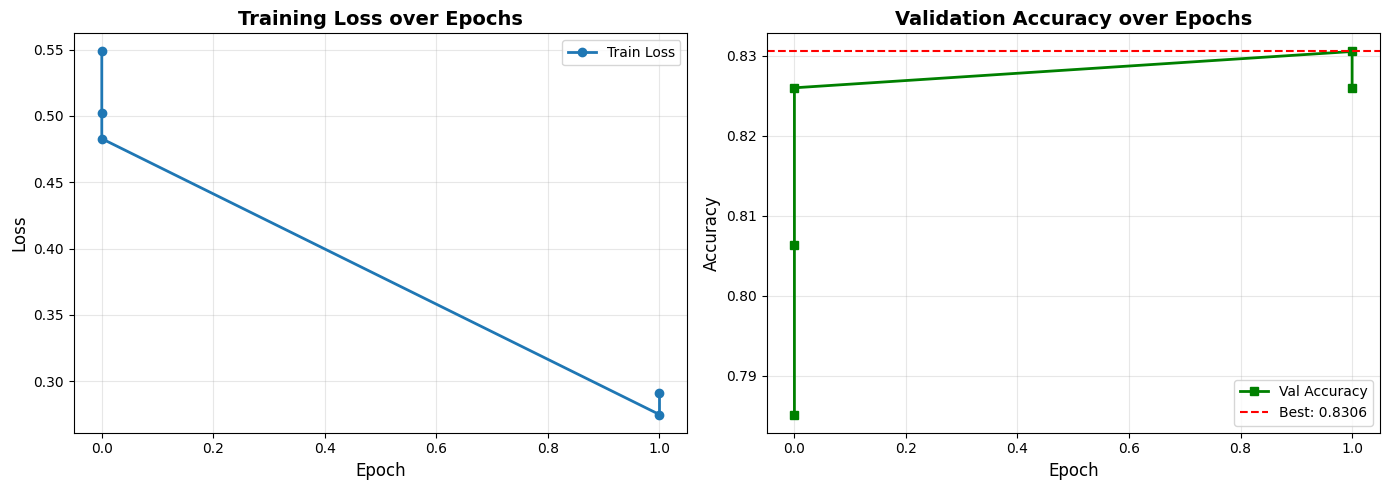

✓ Training curves saved to ..\reranker_finetune\training_curves.png


In [13]:
import matplotlib.pyplot as plt

# Create training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss
if training_history["train_loss"]:
    ax1.plot(training_history["epoch"], training_history["train_loss"], marker='o', label='Train Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Validation Accuracy
if training_history["val_accuracy"]:
    val_acc_values = training_history["val_accuracy"]
    ax2.plot(training_history["epoch"], val_acc_values, marker='s', color='green', label='Val Accuracy', linewidth=2)
    
    # --- FIX START ---
    # Calculate the actual best accuracy from the history list
    best_acc = max(val_acc_values) 
    ax2.axhline(y=best_acc, color='r', linestyle='--', label=f'Best: {best_acc:.4f}')
    # --- FIX END ---

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {OUTPUT_DIR / 'training_curves.png'}")

## 9. Save Fine-tuned Model

## 10. Test Fine-tuned Model

In [14]:
# Load the saved model for testing
test_model = CrossEncoder(str(final_model_path), device=device)

# Test with sample queries
test_queries = [
    "Đặc trưng của phần mềm là gì?",
    "Giai đoạn xác định trong phát triển phần mềm bao gồm các bước gì?",
    "Giai đoạn bảo trì phần mềm là gì?"
]

# Get some random chunks for testing
sample_chunks = list(chunks_col.find().limit(5))

print("Testing fine-tuned model:")
print("="*80)

for query in test_queries:
    print(f"\nQuery: {query}")
    print("-" * 80)
    
    # Score all sample chunks
    scores = []
    for chunk in sample_chunks:
        chunk_text = chunk["text"][:500]  # Limit for display
        score = test_model.predict([(query, chunk_text)])[0]
        scores.append((score, chunk_text[:150]))
    
    # Sort by score (descending)
    scores.sort(reverse=True, key=lambda x: x[0])
    
    # Display top 3
    for i, (score, text) in enumerate(scores[:3], 1):
        print(f"  {i}. Score: {score:.4f}")
        print(f"     Text: {text}...")
        print()

print("="*80)
print("✓ Model testing complete")

Testing fine-tuned model:

Query: Đặc trưng của phần mềm là gì?
--------------------------------------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1. Score: 0.6458
     Text: Lịch sử phát triển phần mềm (tiếp) • 1960-1970: – Hệ thống đa người dùng dẫn đến khái niệm mới về tương tác người máy. – Hệ thống thời gian thực. – Ti...

  2. Score: 0.5363
     Text: Phần mềm • Phần mềm software: – Nghĩa hẹp: Là các chương trình máy tính và những tài liệu liên quan (tài liệu đặc tả yêu cầu, tài liệu phân tích thiết...

  3. Score: 0.3932
     Text: Nội dung 1. Phần mềm – Định nghĩa phần mềm – Lịch sử phát triển phần mềm – Các đặc trưng phần mềm – Phân loại phần mềm – Các thành phần của phần mềm –...


Query: Giai đoạn xác định trong phát triển phần mềm bao gồm các bước gì?
--------------------------------------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1. Score: 0.3547
     Text: Phần mềm • Phần mềm software: – Nghĩa hẹp: Là các chương trình máy tính và những tài liệu liên quan (tài liệu đặc tả yêu cầu, tài liệu phân tích thiết...

  2. Score: 0.3371
     Text: Lịch sử phát triển phần mềm • Sự tiến hóa của phần mềm gắn liền với sự tiến hóa của phần cứng và có thể chia làm bốn giai đoạn: – 1950-1960: • Phần cứ...

  3. Score: 0.2876
     Text: Lịch sử phát triển phần mềm (tiếp) • 1960-1970: – Hệ thống đa người dùng dẫn đến khái niệm mới về tương tác người máy. – Hệ thống thời gian thực. – Ti...


Query: Giai đoạn bảo trì phần mềm là gì?
--------------------------------------------------------------------------------


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1. Score: 0.1039
     Text: Lịch sử phát triển phần mềm (tiếp) • 1960-1970: – Hệ thống đa người dùng dẫn đến khái niệm mới về tương tác người máy. – Hệ thống thời gian thực. – Ti...

  2. Score: 0.0764
     Text: Phần mềm • Phần mềm software: – Nghĩa hẹp: Là các chương trình máy tính và những tài liệu liên quan (tài liệu đặc tả yêu cầu, tài liệu phân tích thiết...

  3. Score: 0.0190
     Text: Lịch sử phát triển phần mềm • Sự tiến hóa của phần mềm gắn liền với sự tiến hóa của phần cứng và có thể chia làm bốn giai đoạn: – 1950-1960: • Phần cứ...

✓ Model testing complete


## 11. Evaluation on Gold Standard (Optional)

In [ ]:
# Load gold standard Q&A pairs if available
qa_gold_path = Path("qa_gold.csv")

if qa_gold_path.exists():
    print("Evaluating on gold standard Q&A pairs...")
    
    # Load gold standard
    qa_gold = pd.read_csv(qa_gold_path)
    print(f"Loaded {len(qa_gold)} gold standard Q&A pairs")
    
    # You can add custom evaluation logic here
    # For example, compare retrieval performance with and without the fine-tuned model
    # This would require running the full RAG pipeline
    
    print("Note: Full evaluation requires running eval_run.py with the fine-tuned model")
    print("Update your .env file first:")
    print(f'  RERANKER_MODEL="{final_model_path.absolute()}"')
    print("Then run: python eval_run.py")
else:
    print(f"Gold standard file not found: {qa_gold_path}")
    print("Skipping gold standard evaluation")